# Orchestrator-Worker con LangGraph

## Definición (nivel MIT/Stanford, aplicada)
El orquestador descompone dinámicamente la tarea en N trabajos y workers especializados ejecutan cada frente. Luego se sintetiza.

## Cuándo usarla
Úsala cuando la cantidad de subtareas no es fija y cambia por contexto.

## Cuándo NO usarla
No la uses para tareas pequeñas y estables; sobre-ingeniería innecesaria.

## Diagrama Conceptual

```mermaid
graph TD
A[Contexto] --> B[Orquestador]
B --> C1[Worker 1]
B --> C2[Worker 2]
B --> C3[Worker N]
C1 --> D[Síntesis]
C2 --> D
C3 --> D
```

In [1]:
# Setup de clase
from __future__ import annotations

import importlib.util
import inspect
import json
import sys
from pathlib import Path
from IPython.display import Image, Markdown, display


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("No se encontro raiz del repo")


def load_module(path: Path, module_name: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    if spec is None or spec.loader is None:
        raise RuntimeError(f"No se pudo cargar modulo: {path}")
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

ROOT = find_repo_root(Path.cwd())
print(f"Repo root: {ROOT}")

Repo root: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry


In [2]:
script_path = ROOT / '04_langchain_langgraph/03_orchestrator_worker/Notebooks/01_orchestrator_worker_langgraph.py'
module = load_module(script_path, 'nb_orch_worker')
run_fn = module.run_orchestrator_worker
print('Script:', script_path)
print('Función:', run_fn.__name__)

Script: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/04_langchain_langgraph/03_orchestrator_worker/Notebooks/01_orchestrator_worker_langgraph.py
Función: run_orchestrator_worker


## Código de la arquitectura (visible en notebook)

In [3]:
print(inspect.getsource(run_fn)[:5000])

def run_orchestrator_worker(profile: dict | None = None, verbose: bool = True) -> dict:
    root = find_repo_root(Path.cwd())
    load_dotenv(root / ".env")
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY no esta definida en .env")

    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    llm = ChatOpenAI(model=model, temperature=0.4, api_key=api_key)

    build_context_packet = load_context_builder(root)
    if profile is None:
        profile = {
            "tipo_persona": "fundadora de startup climate-tech",
            "gustos": ["trail running", "cafes de especialidad", "documentales de ciencia", "arte contemporaneo"],
            "estilo": "directa, curiosa, orientada a impacto",
            "contexto": "primera conversacion luego de coincidir en evento tech",
        }
    context_packet = build_context_packet(profile=profile, architecture="orchestrator_worker")

    def orchestrate(state: OrchestratorState) -> dict:
    

## Ejemplo 1: caso base del curso

In [4]:
result_1 = run_fn(verbose=False)
print('Modelo:', result_1['__model'])
print('Context hash:', result_1['__context_hash'])

Modelo: gpt-4o-mini
Context hash: 337f5300002a


In [5]:
print('Salida final ejemplo 1:')
print(json.dumps(result_1['final'], ensure_ascii=False, indent=2))

Salida final ejemplo 1:
{
  "opener": "Hola, soy fundadora de una startup climate-tech. Me apasiona el trail running y disfruto de los cafés de especialidad. ¿Tú también tienes intereses en la sostenibilidad?",
  "follow_up": "Me encanta explorar cafés de especialidad. ¿Tienes alguna recomendación de lugares que hayas visitado? Siempre busco nuevas experiencias en el mundo del café.",
  "why_it_works": [
    "Establece conexión inmediata al compartir intereses personales.",
    "Invita a la otra persona a compartir sus propias experiencias y gustos.",
    "Fomenta una conversación sobre sostenibilidad, un tema relevante para ambos."
  ]
}


## Grafo real LangGraph (comportamiento)

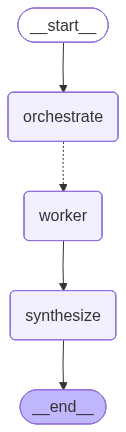

In [6]:
agent = result_1['__agent']
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as exc:
    print('No se pudo renderizar PNG en este entorno:', exc)
    display(Markdown('```mermaid\n' + result_1['__graph_mermaid'] + '\n```'))

## Ejemplo 2: asistente latino experto en enamorar (coqueteo creativo y respetuoso)

In [7]:
profile_coqueteo = {
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}
result_2 = run_fn(profile=profile_coqueteo, verbose=False)
print('Context hash coqueteo:', result_2['__context_hash'])

Context hash coqueteo: 5c0868294502


In [8]:
print('Salida final ejemplo coqueteo:')
print(json.dumps(result_2['final'], ensure_ascii=False, indent=2))

Salida final ejemplo coqueteo:
{
  "opener": "¿Te gusta la salsa romántica? Imagínate un café bohemio, con buena música y una conversación que fluye como el ritmo. ¿Cuál es tu canción favorita para ese momento?",
  "follow_up": "¿Te gustaría compartir un café bohemio y hablar de poesía urbana? Creo que una buena charla puede ser tan encantadora como un paseo nocturno bajo las estrellas.",
  "why_it_works": [
    "Utiliza intereses compartidos para crear conexión.",
    "Evoca imágenes sensoriales que invitan a la imaginación.",
    "Incorpora un toque de misterio y encanto sin ser explícito."
  ]
}


## Errores típicos en producción
- Elegir esta arquitectura por moda y no por necesidad.
- No definir métricas de calidad/costo/latencia antes de escalar.
- No versionar contexto ni criterios de evaluación.
- Falta de observabilidad para diagnosticar degradaciones.

## Lectura crítica del resultado
- Evalúa si el flujo realmente mejoró calidad o solo añadió complejidad.
- Compara latencia/costo vs beneficio de control arquitectónico.
- Decide si esta arquitectura es mínima suficiente para tu caso real.